In [1]:
%autosave 60
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import deepcopy as copy

Autosaving every 60 seconds


If you download the code from github:

In [2]:
code_dir = '/Users/xychen/Documents/Astro/Code/s3fit/' # please change to your local path for the downloaded S3Fit directory

import sys, os
sys.path.append(os.path.abspath(code_dir)) 
from S3Fit.s3fit import FitFrame

If you install with pip:

In [3]:
# from s3fit import FitFrame

#### The example uses S3Fit v2.3

This example shows a pure-spectral fitting for a quasar. \
It is highly recommended to read the [manual](https://github.com/xychcz/S3Fit/blob/main/manuals/basic_usage.md) 
and also refer to another more detailed [example](https://github.com/xychcz/S3Fit/blob/main/example/example_galaxy.ipynb)
to learn about tht basic usage of S3Fit before running the example. \
It is also suggested to check the [full parameter list](https://github.com/xychcz/S3Fit/blob/main/manuals/full_parameter_list.md) 
and the [advanced usage](https://github.com/xychcz/S3Fit/blob/main/manuals/advanced_usage.md) if you try to customize the fitting.

# 1. Example data

Input spectral data

In [4]:
example = fits.open('example_quasar_spec_w.fits')[1].data
spec_wave_w = 10**np.array([example[i][1] for i in range(len(example))])
spec_flux_w = np.array([example[i][0] for i in range(len(example))])*1e-17
spec_ferr_w = np.array([example[i][2] for i in range(len(example))])**(-1/2)*1e-17

spec_valid_range = None
spec_R_inst_w = (2500-1500)/(9000-3800)*(spec_wave_w-3800) + 1500 # 1500 at 3800 Å, 2500 at 9000 Å

v0_redshift = 0.75048 # a rough guess of systemic redshift

# 2. Set models

In this case we use the AGN UV/optical continua and line models.\
There are three continuum components: powerlaw, Fe II pseudo-continuum, and Balmer continuum.

In [12]:
agn_config = {'powerlaw'    : {'pars': [[None, None, 'agn:Fe II:0'], # velocity shift (km/s), which is tied to Fe II component
                                        [None, None, 'agn:Fe II:1'], # velocity FWHM (km/s), which is tied to Fe II component
                                        [   0, 10.0, 'free'],        # extinction (AV)
                                        [  -3,    0, 'free'],       # spectral index of powerlaw (alpha_lambda) at 0.1-5 micron
                                       ], 
                               'info': {'mod_used': 'powerlaw'} 
                              }, 
              'Fe II'       : {'pars': [[-300,  300, 'free'], # velocity shift (km/s)
                                        [ 100, 1200, 'free'], # velocity FWHM (km/s)
                                        [   0, 10.0, 'free'], # extinction (AV)
                                       ], 
                               'info': {'mod_used': 'iron'} 
                              }, 
              'Balmer cont.': {'pars': [[None, None, 'agn:Fe II:0'], # velocity shift (km/s), which is tied to Fe II component
                                        [None, None, 'agn:Fe II:1'], # velocity FWHM (km/s), which is tied to Fe II component
                                        [   0, 10.0, 'free'],        # extinction (AV)
                                        [3.85, 4.40, 'free'],        # electron temperature (log K)
                                        [  -1,  1.7, 'free'],        # optical depth at Balmer edge (log tau)
                                       ],
                               'info': {'mod_used': 'bac'} 
                              }, 
             }
iron_file = './model_libraries/agn_iron_for_s3fit.fits' # template file of Fe II pseudo-continuum
# please download the file at S3Fit/model_libraries/ in the github page

Here we use three components of emssion lines: narrow lines ('narrow'), broad lines in AGN BLR ('AGN BLR'), broad lines in outflow ('outflow'), 
and an absorption line component ('absorption'). \
The component names can be set following your preference. \
For the 'AGN BLR' component, we use the `'line_used': 'BLR'` preset with high-order Balmer lines enabled `'H_hi_order': True`. \
The `'line_used': 'default'` preset is used for the other three components. \
Please use `'sign': 'absorption'` to set an absorption component (default is `'sign': 'emission'`). \
You can set a Lorentz line profile with `'profile': 'Lorentz'` (default is `'profile': 'Gaussian'`). \
Please read the [basic usage](https://github.com/xychcz/S3Fit/blob/main/manuals/basic_usage.md)
and the [advanced usage](https://github.com/xychcz/S3Fit/blob/main/manuals/advanced_usage.md)
to learn about other line setup, e.g., different line name presets (e.g., allowed or forbidden lines). 

In [11]:
line_config = {'narrow'    : {'pars': [[ -500,   500, 'free'], # velocity shift (km/s)
                                       [  250,  2500, 'free'], # velocity FWHM (km/s)
                                       [    0,     5, 'free'], # extinction (AV)
                                       [  1.3,   4.3, 'free'], # electron density (log cm-3)
                                       [    4,  None, 'fix' ], # electron temperature (log K)
                                      ],
                              'info': {'line_used': 'default'}
                             }, 
               'AGN BLR'   : {'pars': [[ -500,   500, 'free'], 
                                       [  750, 15000, 'free'], 
                                       [    0,     5, 'free'], 
                                       [    9,  None, 'fix' ], 
                                       [    4,  None, 'fix' ],
                                      ], 
                              'info': {'line_used' : 'BLR',    # use 'BLR' line preset for the component
                                       'H_hi_order': True,     # enable high-order Balmer lines for the component
                                      }
                             },             
               'outflow'   : {'pars': [[-2000,   100, 'free'], 
                                       [  750,  4000, 'free'], 
                                       [    0,     5, 'free'], 
                                       [  1.3,   4.3, 'free'], 
                                       [    4,  None, 'fix' ],
                                      ], 
                              'info': {'line_used': 'default'}}, 
               'absorption': {'pars': [[-2000,   100, 'free'], 
                                       [  750,  4000, 'free'], 
                                       [    0,     5, 'free'], 
                                       [  1.3,   4.3, 'free'], 
                                       [    4,  None, 'fix' ],
                                      ], 
                              'info': {'line_used': 'default', 
                                       'sign'     : 'absorption', # set the component to be absorption (default is 'emission')
                                       'profile'  : 'Lorentz',    # use Lorentz profile (default is 'Gaussian')
                                      }
                             }, 
              }

Summarize configurations for all models. Set `'use_pyneb': False` if PyNeb is not installed.

In [7]:
model_config = {'line': {'enable': True, 'config': line_config, 'use_pyneb': True}, 
                'agn' : {'enable': True, 'config': agn_config , 'file': iron_file}}

# 3. Perform fitting with S<sup>3</sup>Fit

## 3.1 Pure spec fit

Starting from initializing the FitFrame.
- Set `num_mocks=0` to fit the original data only, i.e., no fitting is performed for mock spectra. \
- Set `plot_step=True` and `print_step=True` to trace the results in each step. \

In [8]:
FF_qso_spec = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                       spec_R_inst_w=spec_R_inst_w, spec_valid_range=spec_valid_range, 
                       v0_redshift=v0_redshift, model_config=model_config,
                       num_mocks=0, fit_grid='log', examine_result=True, 
                       plot_step=True, print_step=True)

################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 0 mock data.
All continuum models and line components with peak S/N < 2 (set with 'accept_model_SN') will be automatically disabled in examination.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Spectral fitting will be performed in wavelength range (rest frame, AA): from 2146.686 to 5335.765
[Note] The wavelength range is extended for tolerances of redshift of 0.75048+-0.0050 (+-1500 km/s) and convolution/dispersion FWHM of max 1500 km/s.
[WARNING] The input normalization wavelength (rest frame, AA) 5500 is out of the valid range, which is forced to the median valid wavelength 3400.
##########

Run the fit

####################### Loop 1/1 starts (original data) ########################
########################## Fit the original spectrum ###########################
Continuum models used in spectral fitting: agn
#### <cont_fit_init> start: spectral fitting, initialize continuum models.
Perform Dual Annealing optimazation for a rough global search.
Fit with 3 free elements and 8 free parameters of 1 models, reduced chi-squared = 2.823.


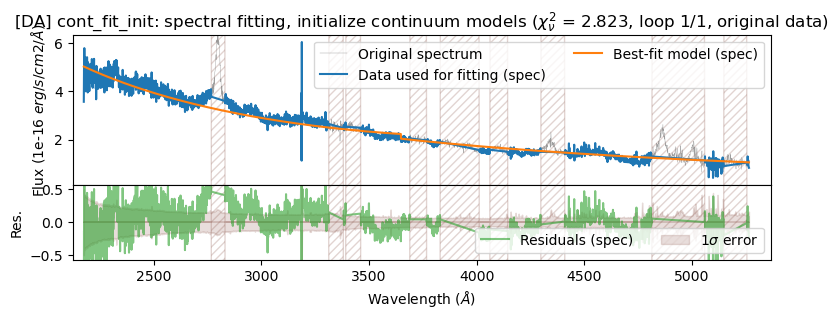

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 3 free elements and 8 free parameters of 1 models, reduced chi-squared = 1.445.


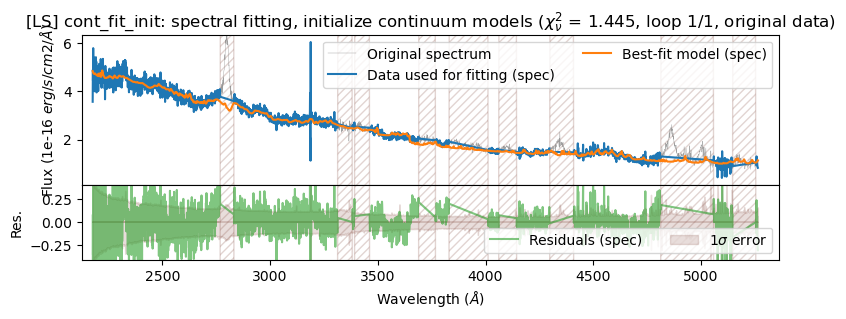

#### <cont_fit_init> finish: 3.2s/3.2s/3.2s spent in this step/loop/total.
#### <line_fit_init> start: spectral fitting, initialize emission lines.
Perform Dual Annealing optimazation for a rough global search.
Fit with 30 free elements and 15 free parameters of 1 models, reduced chi-squared = 1.263.


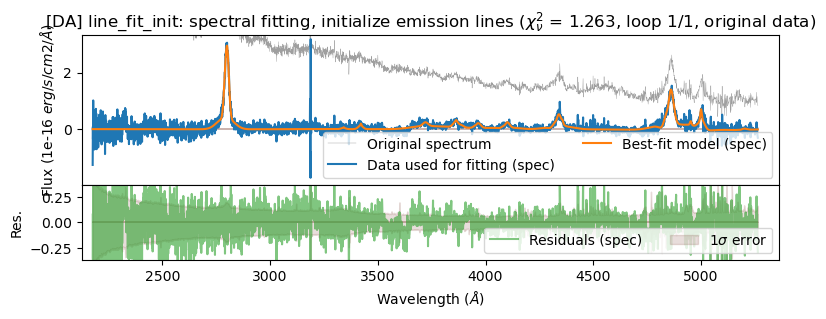

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 30 free elements and 15 free parameters of 1 models, reduced chi-squared = 1.199.


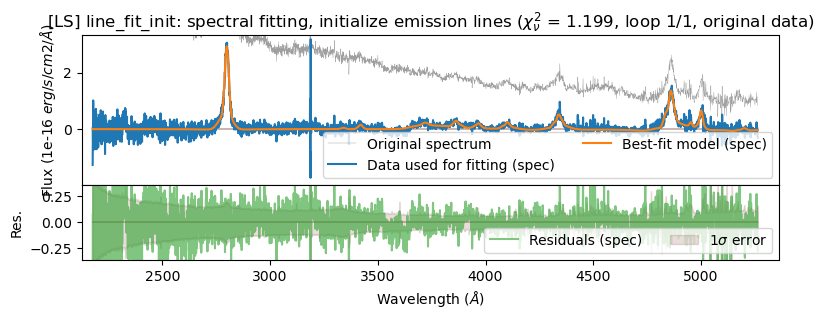

#### <line_fit_init> finish: 17.0s/20.1s/20.1s spent in this step/loop/total.
#### <cont_fit_1> start: spectral fitting, update continuum models.
Perform Dual Annealing optimazation for a rough global search.
Fit with 3 free elements and 8 free parameters of 1 models, reduced chi-squared = 1.343.


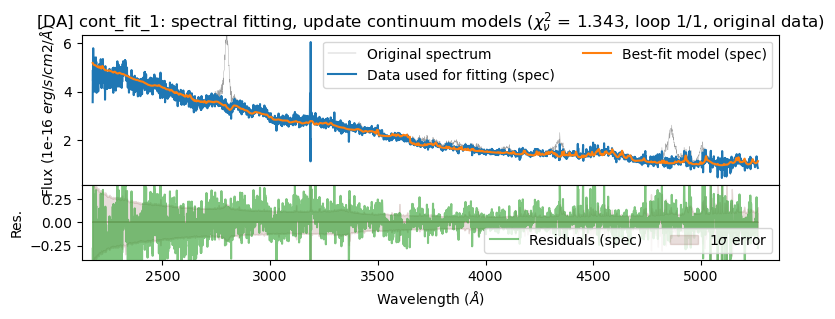

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 3 free elements and 8 free parameters of 1 models, reduced chi-squared = 1.191.


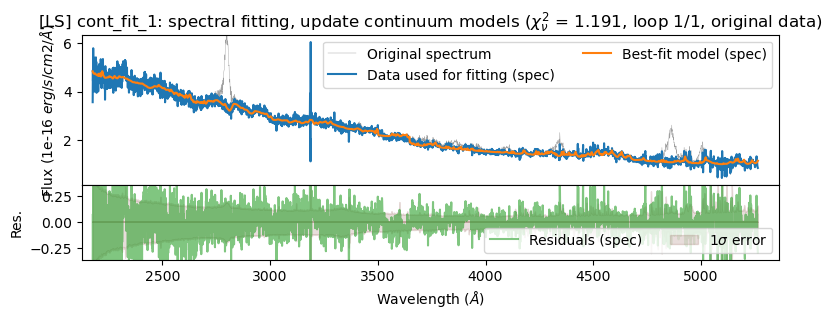

#### <cont_fit_1> finish: 3.4s/23.5s/23.5s spent in this step/loop/total.
Absorption components ['absorption'] are disabled due to low peak S/N = 0.455 (abs) < 2 (set by accept_absorption_SN).
#### <line_fit_1> start: spectral fitting, update emission lines.
Perform Dual Annealing optimazation for a rough global search.
Fit with 21 free elements and 11 free parameters of 1 models, reduced chi-squared = 1.310.


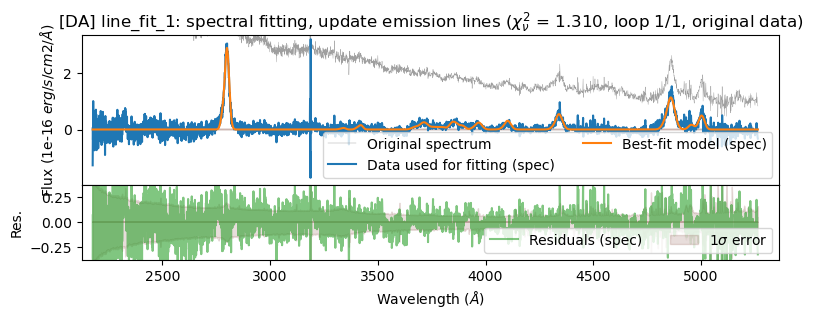

Perform Non-linear Least-square optimazation for fine tuning.
Fit with 21 free elements and 11 free parameters of 1 models, reduced chi-squared = 1.219.


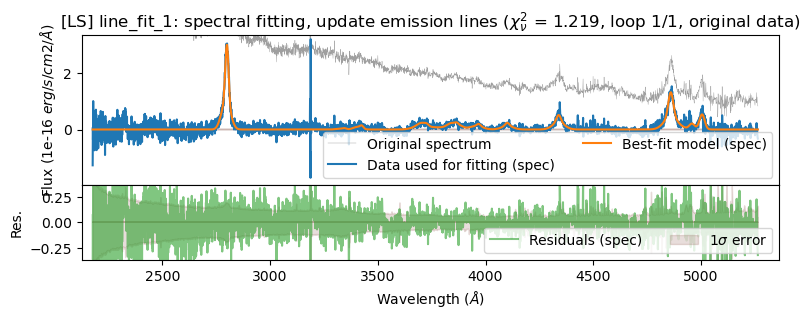

#### <line_fit_1> finish: 15.8s/39.4s/39.4s spent in this step/loop/total.
#### <joint_fit_1> start: spectral fitting, fit with all models.
Perturb transferred parameters with scatters of 2.0% of parameter ranges.
Perform Non-linear Least-square optimazation for fine tuning.
Non-linear fitting cycle 1/3, accept this fitting with chi_sq = 1.249 / 1.219 (goal) < 110%.
Fit with 24 free elements and 19 free parameters of 2 models, reduced chi-squared = 1.249.


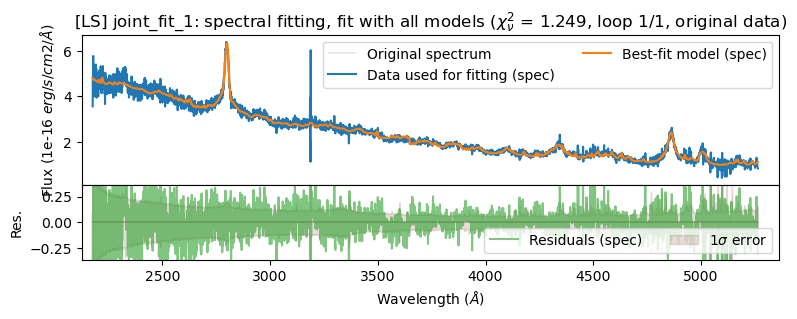

#### <joint_fit_1> finish: 8.0s/47.3s/47.3s spent in this step/loop/total.
#### Examine if each continuum model is indeed required, i.e., with peak S/N >= 2 (set by accept_model_SN). ####
agn continuum peak S/N = 24.896 --> remaining
#### Continuum models after examination: agn
#### Examine if each emission line component is indeed required, i.e., with peak S/N >= 2 (set by accept_model_SN). ####
narrow peak S/N = 8.385 --> remaining
AGN BLR peak S/N = 3.883 --> remaining
outflow peak S/N = 1.700 --> disabled
absorption peak S/N = 0.000 --> disabled
#### Emission line components after examination: ['narrow', 'AGN BLR']
#### <cont_fit_2a> start: spectral fitting, update continuum models.
Do not perturb transferred parameters from the former step.
Perform Non-linear Least-square optimazation for fine tuning.
Fit with 3 free elements and 8 free parameters of 1 models, reduced chi-squared = 1.225.


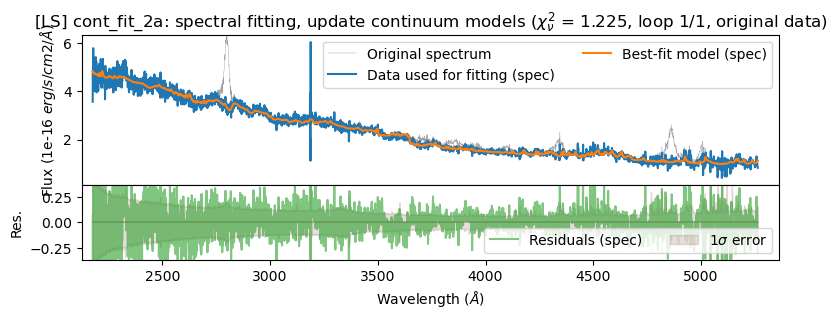

#### <cont_fit_2a> finish: 0.5s/47.9s/47.9s spent in this step/loop/total.
#### <line_fit_2> start: spectral fitting, update emission lines.
Perturb transferred parameters with scatters of 2.0% of parameter ranges.
Perform Non-linear Least-square optimazation for fine tuning.
Fit with 12 free elements and 7 free parameters of 1 models, reduced chi-squared = 1.276.


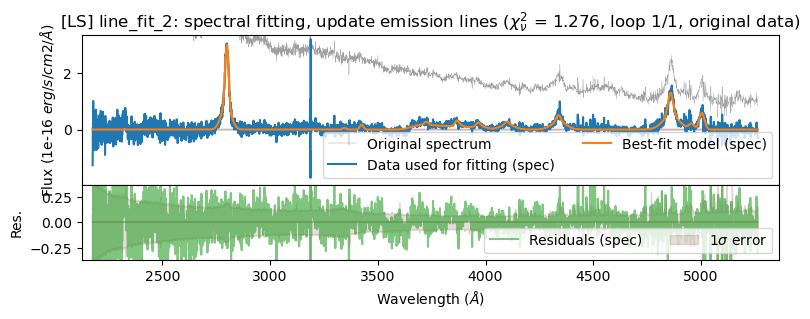

#### <line_fit_2> finish: 3.5s/51.4s/51.4s spent in this step/loop/total.
#### <joint_fit_2> start: spectral fitting, update all models.
Do not perturb transferred parameters from the former step.
Perform Non-linear Least-square optimazation for fine tuning.
Non-linear fitting cycle 1/3, accept this fitting with chi_sq = 1.302 / 1.276 (goal) < 110%.
Fit with 15 free elements and 15 free parameters of 2 models, reduced chi-squared = 1.302.


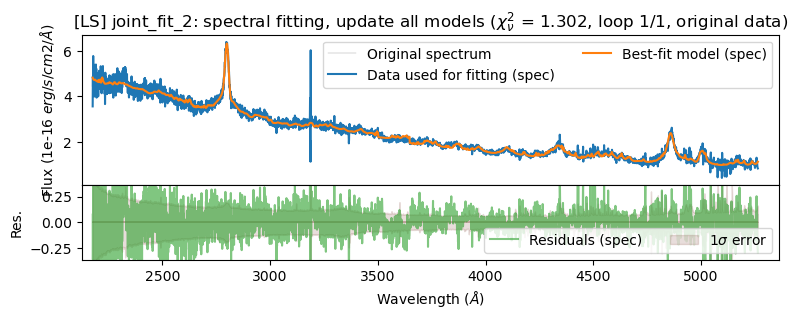

#### <joint_fit_2> finish: 5.4s/56.8s/56.8s spent in this step/loop/total.
##################### Loop 1/1 ends, chi_sq = 1.302 56.8s ######################
1 fitting loops (original data and 0 mock data) have good quality, with chi_sq = [1.302].
No fitting loop needs refitting. Run with main_fit(refit=True) to force refitting.
#################### 1 successful loops in 1 recyles, 56.8s ####################
The best-fit properties are extracted for the models: agn+line

Best-fit properties of AGN component: <powerlaw>
[Note] velocity shift (i.e., redshift) and FWHM are tied following the input model_config.
| Extinction (AV)                                     =     0.3035 +/- 0.0000  |
| Powerlaw α_λ                                        =    -2.1550 +/- 0.0000  |
| λL3000 (rest,intrinsic) (log Lsun)                  =    12.1750 +/- 0.0000  |
| λL5100 (rest,intrinsic) (log Lsun)                  =    11.9088 +/- 0.0000  |
| λL3400 (rest,intrinsic) (log Lsun)                  =    12.

In [9]:
FF_qso_spec.main_fit()

Note that the 'outflow' and 'absorption' components show zero line fluxes, since these components are automatically disabled due to low peak S/N. Please read the above fitting log to learn about the detailes.

## 3.2 Spec fit with mocked spectra (for uncertainty estimation)

Here we also run fitting for 10 mock data to estimate fitting uncertainties. \
The fitting for mock data could be run in multi threading if `use_multi_thread=True` (default is False). You can specify the used number of threads with `num_multi_threads`.\
The fitting status in each step can be hidden if `print_step=False`. \

In [26]:
FF_qso_spec_mock10 = FitFrame(spec_wave_w=spec_wave_w, spec_flux_w=spec_flux_w, spec_ferr_w=spec_ferr_w, 
                              spec_R_inst_w=spec_R_inst_w, spec_valid_range=spec_valid_range, 
                              v0_redshift=v0_redshift, model_config=model_config,
                              num_mocks=10, # use_multi_thread=True, 
                              fit_grid='log', examine_result=True, 
                              plot_step=True, print_step=False)

################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 10 mock data.
All continuum models and line components with peak S/N < 2 (set with 'accept_model_SN') will be automatically disabled in examination.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Spectral fitting will be performed in wavelength range (rest frame, AA): from 2146.686 to 5335.765
[Note] The wavelength range is extended for tolerances of redshift of 0.75048+-0.0050 (+-1500 km/s) and convolution/dispersion FWHM of max 1500 km/s.
[WARNING] The input normalization wavelength (rest frame, AA) 5500 is out of the valid range, which is forced to the median valid wavelength 3400.
#########

<IPython.core.display.Javascript object>


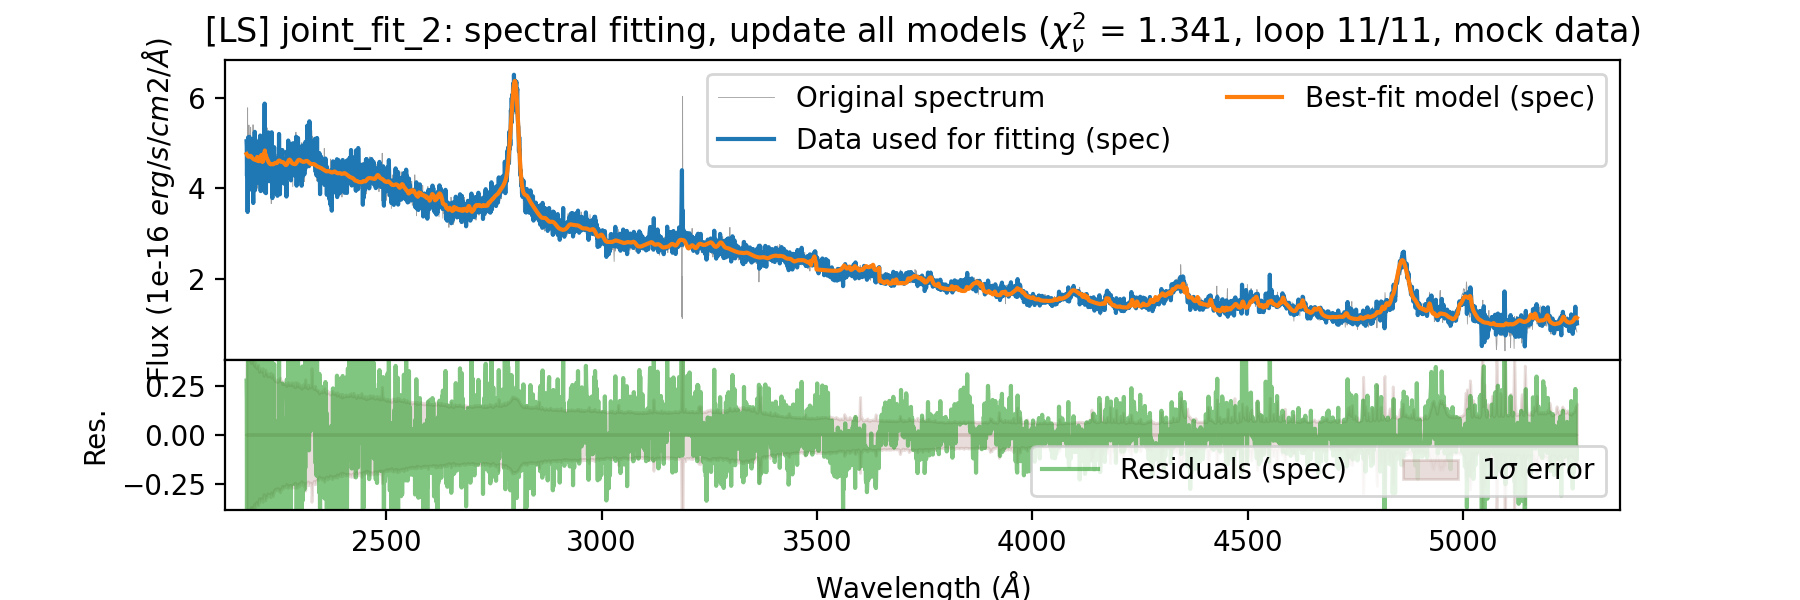

In [27]:
# switch on interactive mode; comment this magic command if you use ipython
%matplotlib notebook 

fig, axs = plt.subplots(2, 1, figsize=(9, 3), dpi=100, gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(bottom=0.15, top=0.9, hspace=0, wspace=0)
plt.show()

FF_qso_spec_mock10.canvas = (fig, axs)

In [28]:
FF_qso_spec_mock10.main_fit()

####################### Loop 1/11 starts (original data) #######################
##################### Loop 1/11 ends, chi_sq = 1.253 78.1s #####################
######################### Loop 2/11 starts (mock data) #########################
##################### Loop 2/11 ends, chi_sq = 1.312 55.1s #####################
######################### Loop 3/11 starts (mock data) #########################
##################### Loop 3/11 ends, chi_sq = 1.440 43.9s #####################
######################### Loop 4/11 starts (mock data) #########################
##################### Loop 4/11 ends, chi_sq = 1.323 52.5s #####################
######################### Loop 5/11 starts (mock data) #########################
##################### Loop 5/11 ends, chi_sq = 1.401 47.5s #####################
######################### Loop 6/11 starts (mock data) #########################
##################### Loop 6/11 ends, chi_sq = 1.384 79.6s #####################
######################### Lo

In this fitting the running message is not shown with print_step=False, which may by helpful to reduce the length in the cell output in fitting with mocked spectra. You can reload the hidded running message by the following command:

In [47]:
# for message in FF_qso_spec_mock10.log_message: print(message)

# 4. Save the results to a file and reload from the file

With the following command, you can easily save the best-fitting results to a compressed pickle file. 

In [29]:
FF_qso_spec_mock10.save_to_file("FF_qso_spec_mock10.pkl.gz")

The input arguments, best-fit results, and running messages are saved to FF_qso_spec_mock10.pkl.gz (a python pickle compressed with gzip).


You can reload the input arguments and best-fit results from the pickle file, and use them to recover a new `FitFrame`. 

In [30]:
FF_new = FitFrame()
FF_new.reload_from_file("FF_qso_spec_mock10.pkl.gz")

[Note] Please input arguments or use FitFrame.reload() to initialize FitFrame.
FitFrame is reloaded from FF_qso_spec_mock10.pkl.gz with the input arguments, best-fit results, and running messages.
################################# S3Fit starts #################################
You are now using S3Fit v2.3.
############################# Initialize FitFrame ##############################
Perform fitting for the original data and 10 mock data.
All continuum models and line components with peak S/N < 2 (set with 'accept_model_SN') will be automatically disabled in examination.
Perform fitting in log space.
[Note] Pure line fitting (i.e., after subtracting continuum), if enabled, is always in linear space.
############################## Read spectral data ##############################
Spectral fitting will be performed in wavelength range (rest frame, AA): from 2146.686 to 5335.765
[Note] The wavelength range is extended for tolerances of redshift of 0.75048+-0.0050 (+-1500 km/s) and convo

You can re-open the running messages to check if there are any issues during the fitting processes. 

In [ ]:
# for message in FF_new.log_message: print(message)

# 5. Format of the output results

Here we use `FF_new` reloaded above for an example. \
S<sup>3</sup>Fit provides a nested dictionary, `FF_new.output_mc`, to display the results of the fitting. \
`FF_new.output_mc` can be calculated for the reloaded `FF_new` with the following command 
(the command is not required if you performa a new fitting by running `FF_new.main_fit()`). 

In [31]:
FF_new.extract_results(step='spec', print_results=False)

Now you can view the results stored in `FF_new.output_mc`. 
Set `print_results=True` if you would like to print the best-fit properties of each model (default is `False`).\
In the above command, 
`step='spec+SED'` means the output results are from the simultaneous spectrum+SED fitting. You can change to `step='spec'` or `step='pure-spec'` to extract the results from the pure-spectrum fitting step (that provides better accuracy for emission lines, see following discussion in emisison line section), or obtain both of the results as follows:

In [32]:
output_spec_mc = FF_new.extract_results(step='pure-spec', return_results=True)

`FF_new.output_mc` contains the following main outputs in a given fitting step. 

- `FF_new.output_mc[mod][comp]['spec_lw']`\
The best-fit model spectra of the `comp` component of the `mod` model.\
For example, `FF_new.output_mc['ssp']['young']['spec_lw'][i_l,i_w]` 
shows the best-fit spectrum of the young stellar population at the `i_w`-th wavelength 
from the `i_l`-th fitting loop (`i_l=0` for the original data and `i_l>=1` for the mock data). 
Replace`'young'` to `'main'` to get the spectrum of the main population, 
or to `'sum'`  to obtain the sum of all stellar components. 
- `FF_new.output_mc[mod][comp]['sed_lw']`\
The best-fit model spectra of the `comp` component of the `mod` model.\
The difference the above two results is that  `'spec_lw'` returns the model spectra in the grid of the input spectral wavelength,
while `'sed_lw'` returns the model spectra in the full SED wavelength range to cover all the input photometric bands. 
Please refer to the following section to learn about examples to display these model spectra. 
- `FF_new.output_mc[mod][comp]['values'][val_name]`\
The calculated properties of the `comp` component of the `mod` model.\
For example, `FF_new.output_mc['ssp']['young']['values']['AV'][i_l]` returns the best-fit dust extinction of stellar continuum
of the young population from the `i_l`-th fitting loop. 
The lists of the names of models, components, and the available values can be obtained as:

In [33]:
for mod in FF_new.rev_model_type.split('+'):
    if mod == 'tot': continue
    comps = [*FF_new.output_mc[mod]]
    if len(comps) == 2: comps = comps[:-1] # do not show 'sum' if the model has only one component
    print(f">>>> '{mod}' model has components of '{comps}'\n List of value names: {[*FF_new.output_mc[mod][comps[0]]['values']]}")

>>>> 'agn' model has components of '['powerlaw', 'Fe II', 'Balmer cont.', 'sum']'
 List of value names: ['voff', 'fwhm', 'AV', 'index_alpha', 'flux_3000', 'flux_5100', 'flux_wavenorm', 'loglambLum_3000', 'loglambLum_5100', 'loglambLum_wavenorm']
>>>> 'line' model has components of '['narrow', 'AGN BLR', 'outflow', 'absorption', 'sum']'
 List of value names: ['voff', 'fwhm', 'AV', 'e_den', 'e_temp', 'Mg II]:2796', 'Mg II]:2804', '[Ne V]:3347', '[Ne V]:3427', 'H40', 'H39', 'H38', 'H37', 'H36', 'H35', 'H34', 'H33', 'H32', 'H31', 'H30', 'H29', 'H28', 'H27', 'H26', 'H25', 'H24', 'H23', 'H22', 'H21', 'H20', 'H19', 'H18', 'H17', 'H16', 'H15', 'H14', '[O II]:3727', '[O II]:3730', 'H13', 'H12', 'H11', 'H10', 'H9', '[Ne III]:3870', 'H8', '[Ne III]:3969', 'H7', 'Hd', 'Hg', '[O III]:4364', 'Hb', '[O III]:4960', '[O III]:5008', '[N I]:5199', '[N I]:5202']


Please read the following sections to learn about the details of these values. \
`FF_new.output_mc` also stores the direct outputs of S<sup>3</sup>Fit, such as:

- `FF_new.output_mc[mod][comp]['par_lp']`\
Best-fit model parameters (non-linear). \
Example: `FF_new.output_mc['ssp']['young']['par_lp'][i_l,i_p]` gives the best-fit `i_p`-th parameter (e.g., `i_p=0` for velocity shift) of the young stellar population in the `i_l`-th fitting loop. The parameters are sorted following the order specified in the input `model_config` dictionary. 
- `FF_new.output_mc[mod][comp]['coeff_le']`\
Best-fit model coefficients (linear), i.e., normalization factors of each model elements. \
Example: `FF_new.output_mc['line']['NLR']['coeff_le'][i_l,i_e]` gives the best-fit coefficient of the `i_e`-th model element of narrow component of emission line models in the `i_l`-th fitting loop. 
The values of the coefficients depends on how the models are normlized. 
For emssion line models, the coefficients are indeed the velocity-integrated line flux, in unit of the the input spectrum.\
The best-fit model spectra and valued properties are calculated from `par_lp` and `coeff_le`. 

Finally, `FF_new.output_mc` provides the best-fit spectra of total models in both of the ranges of the input spectrum or the full SED. They can be obtianed as follows. \
`_l` prefix denotes the fitting loop number, where `i_l=0` for the original data and `i_l>=1` for the mock data. \
`_w` and `_b` represent wavelength of spectrum or SED and bands photometric data points, respectively. \

- `FF_new.output_mc['tot']['fmod']['spec_lw'][i_l,i_w]`
- `FF_new.output_mc['tot']['fmod']['sed_lw'][i_l,i_w]`
- `FF_new.output_mc['tot']['fmod']['phot_lb'][i_l,i_b]`

You can replace `'fmod'` above with 
- `'flux'` to obtain the mock data created in each fitting loop;
- `'ferr'` to obtain the errors used in each fitting loop, which are the original measurement errors in the pure-spectral fitting step, or the scaled errors to account for the calibration errors across different instruments;
- `'fres'` to obtain fitting residuals, i.e., `'flux'-'fmod'` in each loop.

# 6. Display best-fit model spectra

In [34]:
# switch on interactive mode; comment this magic command if you use ipython
%matplotlib inline 

As mentioned above, the best-fit model spectra are stored in 
- `FF_new.output_mc[mod][comp]['spec_lw']` in the wavelength range of the input observed spectrum and 
- `FF_new.output_mc[mod][comp]['sed_lw']` in the wavelength range of the full SED to cover all input photometric data. \

`FF_new.output_mc[mod][comp]['spec_lw'][i_l,i_w]`shows the best-fit spectrum of the component `comp` of the model `mod`, 
at the `i_w`-th wavelength in the `i_l`-th loop. 
`i_l=0` corresponds to the best-fit result for the original data
and `i_l>=1` for mock data. \
`FF_new.output_mc[mod]['sum']['spec_lw']` shows the sum of all components of the model `mod`.\
`FF_new.output_mc['tot']['fmod']['spec_lw']` shows the total model spectra of all models.\
You can check all available model components with the following command.

In [35]:
print("All available model components:")
for mod in FF_new.rev_model_type.split('+'):
    print(f"Model '{mod}' has components: {[*FF_new.output_mc[mod]][:-1]}")

All available model components:
Model 'agn' has components: ['powerlaw', 'Fe II', 'Balmer cont.']
Model 'line' has components: ['narrow', 'AGN BLR', 'outflow', 'absorption']


You can also plot \
`FF_new.output_mc['tot']['flux']['spec_lw'][i_l]` for the original data if `i_l=0` or mock data if `i_l>=1`; \
`FF_new.output_mc['tot']['ferr']['spec_lw'][i_l]` for the original measurement errors if you specify `step='spec'` above; 
or the scaled errors accounting for calibration uncertainties if you specify `step='spec+SED'`;\
`FF_new.output_mc['tot']['fres']['spec_lw'][i_l]` for the fitting residuals. \
Please replace `'spec_lw'` with `'sed_lw'` or `'phot_lb'` for spectra in the SED range and the corresponding photometric data points. \
The original fluxes and errors of the input spectrum and photometric data are also stored in: \
`FF_new.spec['flux_w']` = `FF_new.output_mc['tot']['flux']['spec_lw'][0]`\
`FF_new.spec['ferr_w']` = `FF_new.output_mc['tot']['ferr']['spec_lw'][0]`\
`FF_new.phot['flux_b']` = `FF_new.output_mc['tot']['flux']['phot_lb'][0]`\
`FF_new.phot['ferr_b']` = `FF_new.output_mc['tot']['ferr']['phot_lb'][0]`

Firstly we show the spectra in the wavelength range of the input spectrum. Define a factor `tmp_z` to determine whether to show the results in the observed frame or the rest frame. 

In [37]:
# tmp_z = 1  # show in observed wavelength
tmp_z = (1+FF_new.v0_redshift)  # show in rest wavelength

Text(0.5, 0, 'Rest wavelength ($\\AA$)')

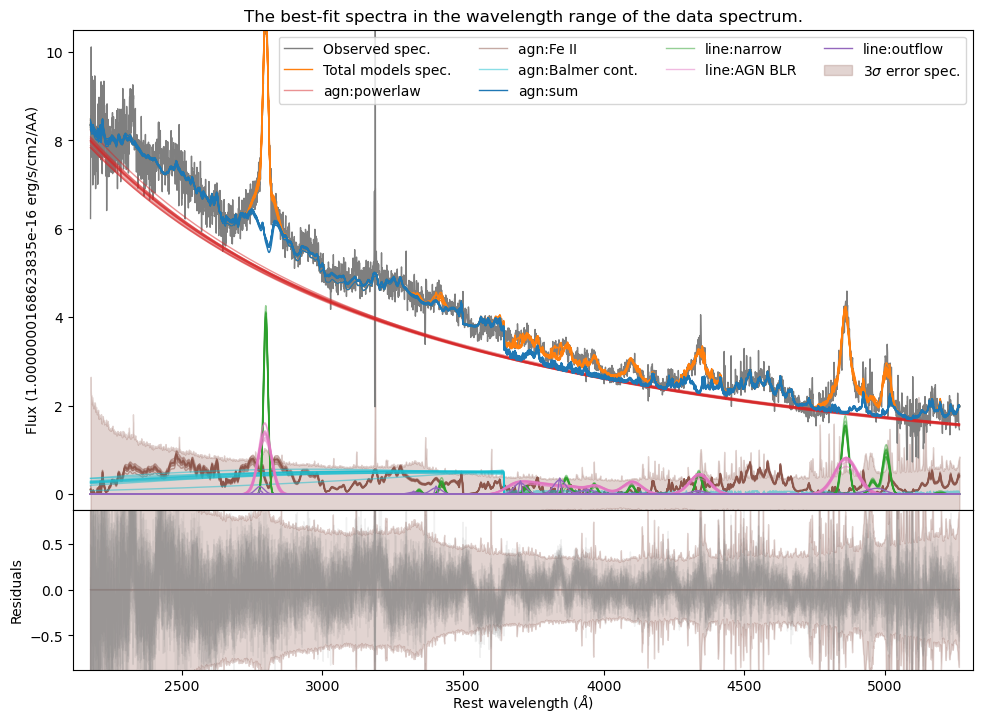

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=100, gridspec_kw={'height_ratios':[3,1]})
plt.subplots_adjust(bottom=0.12, top=0.92, left=0.08, right=0.98, hspace=0, wspace=0)
ax1, ax2 = axs

#####################
# plot original data
ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.spec['flux_w']*tmp_z , c='C7', linewidth=1, label='Observed spec.')
#####################

#####################
# plot model spectra
for i_loop in range(FF_new.num_loops): 
    line, = ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fmod']['spec_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C1', alpha=1)
    if i_loop == 0: line.set_label('Total models spec.')
        
mod = 'agn'
for (i_comp, (color, alpha)) in enumerate(zip(['C3', 'C5','C9','C0'],[0.5,0.5,0.5,1])):
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['spec_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
            
mod = 'line' # here we hide total emission line spectra
for (i_comp, (color, alpha)) in enumerate(zip(['C2','C6','C4'],[0.5,0.5,1])): 
    comp = [*FF_new.output_mc[mod]][i_comp]
    for i_loop in range(FF_new.num_loops): 
        line, = ax1.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc[mod][comp]['spec_lw'][i_loop]*tmp_z, 
                         '-', linewidth=1, color=color, alpha=alpha)
        if i_loop == 0: line.set_label(mod+':'+comp)
#####################

#####################
# plot residuals
for i_loop in range(FF_new.num_loops): 
    line, = ax2.plot(FF_new.spec['wave_w']/tmp_z, FF_new.output_mc['tot']['fres']['spec_lw'][i_loop]*tmp_z, 
                     '-', linewidth=1, color='C7', alpha=0.1)
    if i_loop == 0: line.set_label('Residuals')
#####################

#####################
# plot original spectral errors and invalid range
for ax in axs:
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -3*FF_new.spec['ferr_w']*tmp_z, 3*FF_new.spec['ferr_w']*tmp_z, 
                     fc='C5', ec='C5', alpha=0.25, label=r'3$\sigma$ error spec.')
    ax.fill_between(FF_new.spec['wave_w']/tmp_z, -1*~FF_new.spec['mask_valid_w'], 10*~FF_new.spec['mask_valid_w'], 
                     hatch='////', fc='None', ec='C5', alpha=0.5) # show the masked out range
    ax.set_xlim(3.7e3/tmp_z,9.3e3/tmp_z)
#####################

ax1.legend(ncol=4, loc=1)
ax1.set_ylim(-0.2*tmp_z,6*tmp_z); ax2.set_ylim(-0.5*tmp_z,0.5*tmp_z)
ax1.tick_params(axis='x', which='both', labelbottom=False)
ax1.set_title('The best-fit spectra in the wavelength range of the data spectrum.')
ax1.set_ylabel(f'Flux ({FF_new.spec_flux_scale} erg/s/cm2/AA)')
ax2.set_ylabel(f'Residuals')
ax2.set_xlabel(r'Rest wavelength ($\AA$)', labelpad=-1)

In examples above, the best-fit model spectra from all fitting loops for mock data is displayed. 
If you only would like to show the model spectra for the fitting of the original data, 
please replace loops starting by `for i_loop in range(FF_new.num_loops)` 
with `i_loop = 0`. 

# 7. Print and retrieve properties of best-fit models

## 7.1 AGN UV/optical continuum models

Set `show_average=True` to print the average values of each properties in the fitting loops, 
or `show_average=False` to print the value from the fitting of the original data (i.e., the 0th loop). 

In [52]:
mod = 'agn'
output_agn_c = FF_new.model_dict[mod]['spec_mod'].extract_results(ff=FF_new, step='spec', 
                                                                  print_results=True, return_results=True, show_average=True)


Best-fit properties of AGN component: <powerlaw>
[Note] velocity shift (i.e., redshift) and FWHM are tied following the input model_config.
| Extinction (AV)                                     =     0.6397 +/- 0.2324  |
| Powerlaw α_λ                                        =    -2.5376 +/- 0.2418  |
| λL3000 (rest,intrinsic) (log Lsun)                  =    12.4023 +/- 0.1587  |
| λL5100 (rest,intrinsic) (log Lsun)                  =    12.0479 +/- 0.1032  |
| λL3400 (rest,intrinsic) (log Lsun)                  =    12.3187 +/- 0.1456  |
| F3000 (rest,extinct) (1e-16 erg/s/cm2/AA)           =     2.5306 +/- 0.0159  |
| F5100 (rest,extinct) (1e-16 erg/s/cm2/AA)           =     0.9532 +/- 0.0081  |
| F3400 (rest,extinct) (1e-16 erg/s/cm2/AA)           =     2.0149 +/- 0.0096  |

Best-fit properties of AGN component: <Fe II>
| Velocity shift (km/s)                               =   -68.9459 +/- 42.7305 |
| Velocity FWHM (km/s)                                =   525.7600 +/- 310.7754|
| 

Results are stored in the returned dictionary `output_agn_c` (you can also retrieve using `FF_new.output_mc['agn']`). \
`output_agn_c` has is a nested dictionary with the following items:
- `output_agn_c[comp]['par_lp']`, the best-fit model parameters (non-linear), and 
`output_agn_c[comp]['coeff_le']`, the best-fit model coefficients (linear), i.e., normalization factors of each model elements. 
Please read Section 5. Format of the output results to learn about the meannings of non-linear parameters and linear coefficients. 
You may omit them and focus on the following `'values'` dictionary for a basic usage. 

- `output_agn_c[comp]['values'][val_name]`, the calculated properties of the `comp` component of `agn` model.
The list of the names of the available properties for each component can be obtained as:

In [56]:
print(f"List of value names for the AGN continuum components:")
for comp in [*output_agn_c]:
    print('  ', comp, [*output_agn_c[comp]['values']])

List of value names for the AGN continuum components:
   powerlaw ['voff', 'fwhm', 'AV', 'index_alpha', 'flux_3000', 'flux_5100', 'flux_wavenorm', 'loglambLum_3000', 'loglambLum_5100', 'loglambLum_wavenorm']
   Fe II ['voff', 'fwhm', 'AV', 'flux_3000', 'flux_5100', 'flux_wavenorm', 'logLum_uv', 'logLum_opt']
   Balmer cont. ['voff', 'fwhm', 'AV', 'logtem', 'logtau', 'flux_3000', 'flux_5100', 'flux_wavenorm', 'logLum_int']
   sum ['flux_3000', 'flux_5100', 'flux_wavenorm']


Meanings of each properties\
General
- `'voff'` and `'fwhm'`: velocity shift and dispersion (in FWHM) of Fe II pseudo-continuum, in unit of km/s. The dispersion is corrected for instrumental broadening. 
- `'AV'`: extinction of stellar continua. 
- `'flux_3000'`, `'flux_5100'`, and `'flux_wavenorm'`: flux (F<sub>λ</sub>) at rest 3000 A, 5100 A, and user given normlized wavelength (set by `norm_wave` in FitFrame initialization). F<sub>λ</sub> is the extinct value in unit of factor x erg/s/cm2/AA, where the scaling factor can be obtain with `FF_new.spec_flux_scale`. 

Powerlaw
- `index_alpha`: spectral index (α<sub>λ</sub>) of powerlaw model.
- `'loglambLum_3000'`, `'loglambLum_5100'`, and `'loglambLum_wavenorm'`: luminosity (λL<sub>λ</sub>) at rest 3000 A, 5100 A, and user given normlized wavelength. λL<sub>λ</sub> is the intrinsic value in unit of log Lsun. 

Fe II
- `logLum_uv` and `logLum_opt`: intrinsic luminosity integrated at 2200-4000 A and 4000-5800 A, in unit of log erg/s/cm2. 

Balmer continuum
- `logtem`: electron temperature, in unit of log K. 
- `logtau`: optical depth at Balmer edge, in unit of log tau. 
- `logLum_int`: total integrated intrinsic luminosity, in unit of log erg/s/cm2. 

In [57]:
# example
print(f"Best-fit powerlaw index: {output_agn_c['powerlaw']['values']['index_alpha'].mean():.5f} +- "+
      f"{output_agn_c['powerlaw']['values']['index_alpha'].std():.5f}")

Best-fit powerlaw index: -2.53756 +- 0.24178


## 7.2 Emission lines

Here we print best-fit results of emission lines of different components. \
Set `show_average=True` to print the average values of each properties in the fitting loops, 
or `show_average=False` to print the value from the fitting of the original data (i.e., the 0th loop). 

In [59]:
mod = 'line'
output_line_c = FF_new.model_dict[mod]['spec_mod'].extract_results(ff=FF_new, step='spec', print_results=True, return_results=True)


Best-fit emission line components
|    Par/Line Name     |       narrow       |      AGN BLR       |      outflow       |     absorption     |
|     Voff (km/s)      | - 174.16 +-  34.76 | - 121.31 +-  77.29 | -2000.00 +-   0.00 | -2000.00 +-   0.00 |
|     FWHM (km/s)      |  1726.45 +-  51.43 |  5436.03 +- 356.07 |  4000.00 +- 934.31 |   750.00 +-   0.00 |
|  AV (Balmer decre.)  |     4.66 +-   0.19 |     0.40 +-   0.11 |     4.86 +-   1.40 |     0.00 +-   0.00 |
| log e-density (cm-3) |     2.10 +-   0.65 |     9.00 +-   0.00 |     4.23 +-   0.84 |     1.30 +-   0.00 |
| log e-temperature(K) |     4.00 +-   0.00 |     4.00 +-   0.00 |     4.00 +-   0.00 |     4.00 +-   0.00 |
|     Mg II]:2796      |    30.06 +-   3.70 |    73.78 +-   5.70 |     6.81 +-   1.95 |     0.00 +-   0.00 |
|     Mg II]:2804      |    46.59 +-   4.55 |     0.00 +-   0.00 |     0.00 +-   0.11 |     0.00 +-   0.00 |
|     [Ne V]:3347      |     1.27 +-   0.42 |     0.00 +-   0.00 |     2.26 +-   0.66 |     0

Results are stored in the returned dictionary `output_line_c` (you can also retrieve using `FF_new.output_mc['line']`). 
`output_line_c` has is a nested dictionary with the same structure of `output_ssp_c` shown above. \
The list of the names of the available properties for each component can be obtained as:

In [60]:
print(f"List of value names for the emission line components {[*output_line_c][:-1]}: \n{[*output_line_c[[*output_line_c][0]]['values']]}")

List of value names for the emission line components ['narrow', 'AGN BLR', 'outflow', 'absorption']: 
['voff', 'fwhm', 'AV', 'e_den', 'e_temp', 'Mg II]:2796', 'Mg II]:2804', '[Ne V]:3347', '[Ne V]:3427', 'H40', 'H39', 'H38', 'H37', 'H36', 'H35', 'H34', 'H33', 'H32', 'H31', 'H30', 'H29', 'H28', 'H27', 'H26', 'H25', 'H24', 'H23', 'H22', 'H21', 'H20', 'H19', 'H18', 'H17', 'H16', 'H15', 'H14', '[O II]:3727', '[O II]:3730', 'H13', 'H12', 'H11', 'H10', 'H9', '[Ne III]:3870', 'H8', '[Ne III]:3969', 'H7', 'Hd', 'Hg', '[O III]:4364', 'Hb', '[O III]:4960', '[O III]:5008', '[N I]:5199', '[N I]:5202']


Meanings of each properties:
- `'voff'` and `'fwhm'`: velocity shift and dispersion (in FWHM) of each line, in unit of km/s. The line width is corrected for instrumental broadening. 
- `'AV'`: extinction estimated from Balmer decrement. 
- `'e_den'` and `'e_temp'`: log electron density (cm-3) and temperature (K). 
- other values with the line name: the observed (i.e., extinct) flux of each line in unit of factor x erg/s/cm2, where the scaling factor can be obtain with `FF_new.spec_flux_scale`. 

In [62]:
# example
print(f"Best-fit velocity FWHM of narrow line component (km/s): {output_line_c['narrow']['values']['fwhm'].mean():.5f} +- "+
      f"{output_line_c['narrow']['values']['fwhm'].std():.5f}")
print(f"Best-fit flux of BLR Hbeta ({FF_new.spec_flux_scale:.0e} erg/s/cm2) : {output_line_c['AGN BLR']['values']['Hb'].mean():.5f} +- "+
      f"{output_line_c['AGN BLR']['values']['Hb'].std():.5f}")

Best-fit velocity FWHM of narrow line component (km/s): 1810.26062 +- 51.43009
Best-fit flux of BLR Hbeta (1e-16 erg/s/cm2) : 79.83064 +- 5.06475


### 7.2.1 Line tying relations

In order to reduce the effect of blurring of neighboring emission lines and the contamination of absorption features in stellar continuum, 
S<sup>3</sup>Fit ties the flux ratio of neighboring line doublets 
and Balmer lines. 
The ratios are calculated using pyneb with AV, electron density, and temperature (fixed to 10000 K in this fitting) of each line component.\
The tying relations are summarized in the infomation listed in the FitFrame initialization. \
The following example shows the line ratios of the best-fit narrow component. 

In [63]:
comp = 'AGN BLR'
AV = output_line_c[comp]['values']['AV'][0]
e_den = output_line_c[comp]['values']['e_den'][0]
e_temp = output_line_c[comp]['values']['e_temp'][0]

line_mod = FF_new.model_dict['line']['spec_mod']
line_mod.update_lineratio(AV=AV, logden=e_den, logtem=e_temp)

print(f'Line ratios under the best-fit AV = {AV:.3f}, e- density = {10**e_den:.0f} cm-3, and the fixed e- temperature = {10**e_temp:.0f} K.')
for tied_name in line_mod.linelink_dict:
    i_tied = np.where(line_mod.linename_n == tied_name)[0][0]
    # read flux ratio for given logden and logtem
    ref_name = line_mod.linelink_dict[tied_name]['ref_name']
    print(f'The flux of {tied_name} is tied to {ref_name} with a ratio of {line_mod.lineratio_n[i_tied]:0.4f}.')

Line ratios under the best-fit AV = 0.399, e- density = 1000000000 cm-3, and the fixed e- temperature = 10000 K.
The flux of Hg is tied to Hb with a ratio of 0.4766.
The flux of Hd is tied to Hb with a ratio of 0.2771.
The flux of H7 is tied to Hb with a ratio of 0.1817.
The flux of H8 is tied to Hb with a ratio of 0.1294.
The flux of H9 is tied to Hb with a ratio of 0.0988.
The flux of H10 is tied to Hb with a ratio of 0.0793.
The flux of H11 is tied to Hb with a ratio of 0.0649.
The flux of H12 is tied to Hb with a ratio of 0.0534.
The flux of H13 is tied to Hb with a ratio of 0.0438.
The flux of H14 is tied to Hb with a ratio of 0.0360.
The flux of H15 is tied to Hb with a ratio of 0.0297.
The flux of H16 is tied to Hb with a ratio of 0.0247.
The flux of H17 is tied to Hb with a ratio of 0.0207.
The flux of H18 is tied to Hb with a ratio of 0.0174.
The flux of H19 is tied to Hb with a ratio of 0.0148.
The flux of H20 is tied to Hb with a ratio of 0.0127.
The flux of H21 is tied to H